In [1]:
import time

import numpy as np
import pandas as pd
import torch
from torch import nn
from tqdm import tqdm

# random seed
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## Problem Setting

In [2]:
# init
steepness = 50    # steepness factor
num_blocks = 1    # number of expression blocks
num_data = 9100   # number of data
test_size = 100   # number of test size
val_size = 1000   # number of validation size
train_size = num_data - test_size - val_size

In [3]:
# parameters as input data
p_low, p_high = 1.0, 8.0
a_low, a_high = 0.5, 4.5
p_train = np.random.uniform(p_low, p_high, (train_size, 1)).astype(np.float32)
p_test  = np.random.uniform(p_low, p_high, (test_size, 1)).astype(np.float32)
p_dev   = np.random.uniform(p_low, p_high, (val_size, 1)).astype(np.float32)
a_train = np.random.uniform(a_low, a_high, (train_size, num_blocks)).astype(np.float32)
a_test  = np.random.uniform(a_low, a_high, (test_size, num_blocks)).astype(np.float32)
a_dev   = np.random.uniform(a_low, a_high, (val_size, num_blocks)).astype(np.float32)

In [4]:
# nm datasets
from neuromancer.dataset import DictDataset
data_train = DictDataset({"p":p_train, "a":a_train}, name="train")
data_test = DictDataset({"p":p_test, "a":a_test}, name="test")
data_dev = DictDataset({"p":p_dev, "a":a_dev}, name="dev")
# torch dataloaders
from torch.utils.data import DataLoader
batch_size = 64
loader_train = DataLoader(data_train, batch_size, num_workers=0, collate_fn=data_train.collate_fn, shuffle=True)
loader_test = DataLoader(data_test, batch_size, num_workers=0, collate_fn=data_test.collate_fn, shuffle=False)
loader_dev = DataLoader(data_dev, batch_size, num_workers=0, collate_fn=data_dev.collate_fn, shuffle=True)

C:\Users\lucas\anaconda3\envs\neuromancer\lib\site-packages\mlflow\protos\service_pb2.py:11: UserWarning: google.protobuf.service module is deprecated. RPC implementations should provide code generator plugins which generate code specific to the RPC implementation. service.py will be removed in Jan 2025
  from google.protobuf import service as _service


## Optimization Model

In [5]:
# example data point
p, a = p_test[63], a_test[63]
my_datapoint = {"p": torch.tensor(np.array([p]), dtype=torch.float32), 
                "a": torch.tensor(np.array([a]), dtype=torch.float32),
                "name": "test"}

In [6]:
from src.problem import msRosenbrock
model = msRosenbrock(steepness, num_blocks, timelimit=60)

In [7]:
rng = np.random.RandomState(17)
b = rng.normal(scale=1, size=(num_blocks))
q = rng.normal(scale=1, size=(num_blocks))
print(b, q)

[0.27626589] [-1.85462808]


In [8]:
my_params = {"p":p, "a":a}
model.set_param_val(my_params)
solvals, objval = model.solve()
print(solvals)
print(objval)

{'x': {0: -1.4001008252506861, 1: 2.0}}
31.00221139580013


## Learnable Rounding

In [9]:
# hyperparameters
penalty_weight = 30   # weight of constraint violation penealty
hlayers_sol = 5       # number of hidden layers for solution mapping
hlayers_rnd = 4       # number of hidden layers for solution mapping
hsize = 4             # width of hidden layers for solution mapping
lr = 1e-3             # learning rate

In [10]:
# set problem
import neuromancer as nm
from src.problem import nmRosenbrock
from src.func.layer import netFC
from src.func import roundGumbelModel
# build neural architecture for the solution map
func = nm.modules.blocks.MLP(insize=num_blocks+1, outsize=2*num_blocks, bias=True,
                             linear_map=nm.slim.maps["linear"],
                             nonlin=nn.ReLU, hsizes=[hsize]*hlayers_sol)
smap = nm.system.Node(func, ["p", "a"], ["x"], name="smap")
# define rounding model
layers_rnd = netFC(input_dim=3*num_blocks+1, hidden_dims=[hsize]*hlayers_rnd, output_dim=2*num_blocks)
rnd = roundGumbelModel(layers=layers_rnd, param_keys=["p", "a"], var_keys=["x"],  output_keys=["x_rnd"], 
                       int_ind=model.int_ind, continuous_update=True, name="round")
# build neuromancer problem for rounding
components = nn.ModuleList([smap, rnd])
loss_fn = nmRosenbrock(["p", "a", "x_rnd"], steepness, num_blocks, penalty_weight)

In [11]:
# training
epochs = 200                    # number of training epochs
warmup = 20                     # number of epochs to wait before enacting early stopping policy
patience = 20                   # number of epochs with no improvement in eval metric to allow before early stopping
optimizer = torch.optim.AdamW(components.parameters(), lr=lr)
# init a trainer for the problem
from src.problem.neuromancer.trainer import trainer
my_trainer = trainer(components, loss_fn, optimizer, epochs=epochs, patience=patience, warmup=warmup)
# training for the rounding problem
my_trainer.train(loader_train, loader_dev)

Epoch 0, Iters 0, Validation Loss: 280.75
Epoch 0, Iters 125, Training Loss: 180.04, Validation Loss: 178.37
Epoch 1, Iters 250, Training Loss: 87.52, Validation Loss: 76.65
Epoch 2, Iters 375, Training Loss: 82.01, Validation Loss: 79.32
Epoch 3, Iters 500, Training Loss: 74.56, Validation Loss: 44.86
Epoch 4, Iters 625, Training Loss: 48.05, Validation Loss: 34.33
Epoch 5, Iters 750, Training Loss: 36.80, Validation Loss: 32.68
Epoch 6, Iters 875, Training Loss: 33.99, Validation Loss: 29.35
Epoch 7, Iters 1000, Training Loss: 33.10, Validation Loss: 29.71
Epoch 8, Iters 1125, Training Loss: 33.14, Validation Loss: 28.66
Epoch 9, Iters 1250, Training Loss: 32.94, Validation Loss: 34.28
Epoch 10, Iters 1375, Training Loss: 33.45, Validation Loss: 28.60
Epoch 11, Iters 1500, Training Loss: 32.99, Validation Loss: 26.29
Epoch 12, Iters 1625, Training Loss: 32.96, Validation Loss: 26.43
Epoch 13, Iters 1750, Training Loss: 32.79, Validation Loss: 31.86
Epoch 14, Iters 1875, Training Loss

## Evaluation

In [12]:
# evaluate
import time
from tqdm import tqdm
import pandas as pd
params, sols, objvals, mean_viols, max_viols, num_viols, elapseds = [], [], [], [], [], [], []
for p, a in tqdm(zip(loader_test.dataset.datadict["p"][:100],loader_test.dataset.datadict["a"][:100])):
    # data point as tensor
    datapoints = {"p": torch.tensor(np.array([p]), dtype=torch.float32),
                  "a": torch.tensor(np.array([a]), dtype=torch.float32),
                  "name": "test"}
    # infer
    components.eval()
    tick = time.time()
    with torch.no_grad():
        for comp in components:
            datapoints.update(comp(datapoints))
    tock = time.time()
    # assign params
    model.set_param_val({"p":p, "a":a})
    # assign vars
    x = datapoints["x_rnd"]
    for i in range(len(model.vars["x"])):
        model.vars["x"][i].value = x[0,i].item()
    # get solutions
    xval, objval = model.get_val()
    params.append(list(p)+list(a))
    sols.append(list(list(xval.values())[0].values()))
    objvals.append(objval)
    viol = model.cal_violation()
    mean_viols.append(np.mean(viol))
    max_viols.append(np.max(viol))
    num_viols.append(np.sum(viol > 1e-6))
    elapseds.append(tock - tick)
df = pd.DataFrame({"Param": params,
                   "Sol": sols,
                   "Obj Val": objvals,
                   "Mean Violation": mean_viols,
                   "Max Violation": max_viols,
                   "Num Violations": num_viols,
                   "Elapsed Time": elapseds})
print(df.describe())
print("Number of infeasible solutions: {}".format(np.sum(df["Num Violations"] > 0)))

100it [00:00, 504.22it/s]

          Obj Val  Mean Violation  Max Violation  Num Violations  Elapsed Time
count  100.000000      100.000000     100.000000      100.000000    100.000000
mean     8.763884        0.118930       0.471270        1.050000      0.001204
std      7.801377        0.026236       0.107374        0.219043      0.000567
min      0.102372        0.064006       0.256025        1.000000      0.000000
25%      3.387520        0.098151       0.379389        1.000000      0.001000
50%      6.429420        0.127441       0.505427        1.000000      0.001010
75%     12.243487        0.140634       0.562534        1.000000      0.001505
max     35.363918        0.151935       0.607741        2.000000      0.002378
Number of infeasible solutions: 100


## Projection

In [13]:
class gradientProjection(nn.Module):
    def __init__(self, pre_components, post_components, loss_fn, target_key, output_key, max_iters=1000, step_size=0.01, decay=1.0):
        super().__init__()
        self.pre_components = pre_components
        self.post_components = post_components
        self.loss_fn = loss_fn
        self.target_key = target_key
        self.output_key = output_key
        self.max_iters = max_iters
        self.step_size = step_size
        self.decay = decay
        # init log
        self.rel_seq = []
        self.rnd_seq = []

    def forward(self, input_dict):
        # initialize decay multiplier
        d = 1.0
        # get target variables
        for comp in self.pre_components:
            input_dict.update(comp(input_dict))
        x = input_dict[self.target_key]
        # project gradient
        for _ in range(self.max_iters):
            # forward pass in components
            for comp in self.post_components:
                input_dict.update(comp(input_dict))
            # update logs
            self.rel_seq.append(input_dict[self.target_key][0].detach().numpy())
            self.rnd_seq.append(input_dict[self.output_key][0].detach().numpy())
            # get corresponding violation
            viol = self.loss_fn.cal_constr_viol(input_dict)
            # check stopping condition
            if viol.max() < 1e-6:
                break
            # get gradients
            grad = torch.autograd.grad(viol.sum(), x)[0]
            # update
            x = x - d * self.step_size * grad
            d = self.decay * d
            # get data
            input_dict[self.target_key] = x
        return input_dict

In [14]:
# adjust value
#my_datapoint["x"] -= 3
#my_datapoint.update(rnd(my_datapoint))

In [15]:
proj = gradientProjection([smap], [rnd], loss_fn, "x", "x_rnd")
components.eval()
for comp in components:
    my_datapoint.update(comp(my_datapoint))
proj(my_datapoint)

{'p': tensor([[2.1883]]),
 'a': tensor([[4.1608]]),
 'name': 'test',
 'x': tensor([[0.2216, 2.0011]], grad_fn=<SubBackward0>),
 'x_rnd': tensor([[-8.9729e-04,  2.0000e+00]], grad_fn=<CopySlices>)}

## Visulization

In [16]:
import sympy as sp
from sympy.abc import x, y
from matplotlib import pyplot as plt
import matplotlib.patheffects as patheffects

In [17]:
# objective function
p, a = my_params["p"], my_params["a"]
f = (a.item() - x)**2 + 50*(y - x**2)**2
# constraints
constr1 = x ** 2 <= p.item()
constr2 = y >= p.item() / 2
constr3 = b.item() * x <= 0
constr4 = q.item() * y <= 0

In [18]:
# grid data
x_vals = np.linspace(-1.9, 1.6, 300)
y_vals = np.linspace(-1, 6, 700)
X, Y = np.meshgrid(x_vals, y_vals)

In [19]:
# obj value
Z = sp.lambdify((x, y), f, "numpy")(X, Y)
Z_log = np.log(Z)

In [20]:
# constraint mask
constraint_mask = (
    (X**2 <= p.item()) &
    (Y >= p.item() / 2) &
    (b.item() * X <= 0) &
    (q.item() * Y <= 0)
)

In [21]:
## sol sequence
rels, rnds, sol_seq = [], [], []
for i in [0, 200, -1]:
    rels.append(proj.rel_seq[i])
    sol_seq.append(proj.rel_seq[i])
    rnds.append(proj.rnd_seq[i])
    sol_seq.append(proj.rnd_seq[i])
rels, rnds = np.array(rels), np.array(rnds)
sol_seq = np.array(sol_seq)

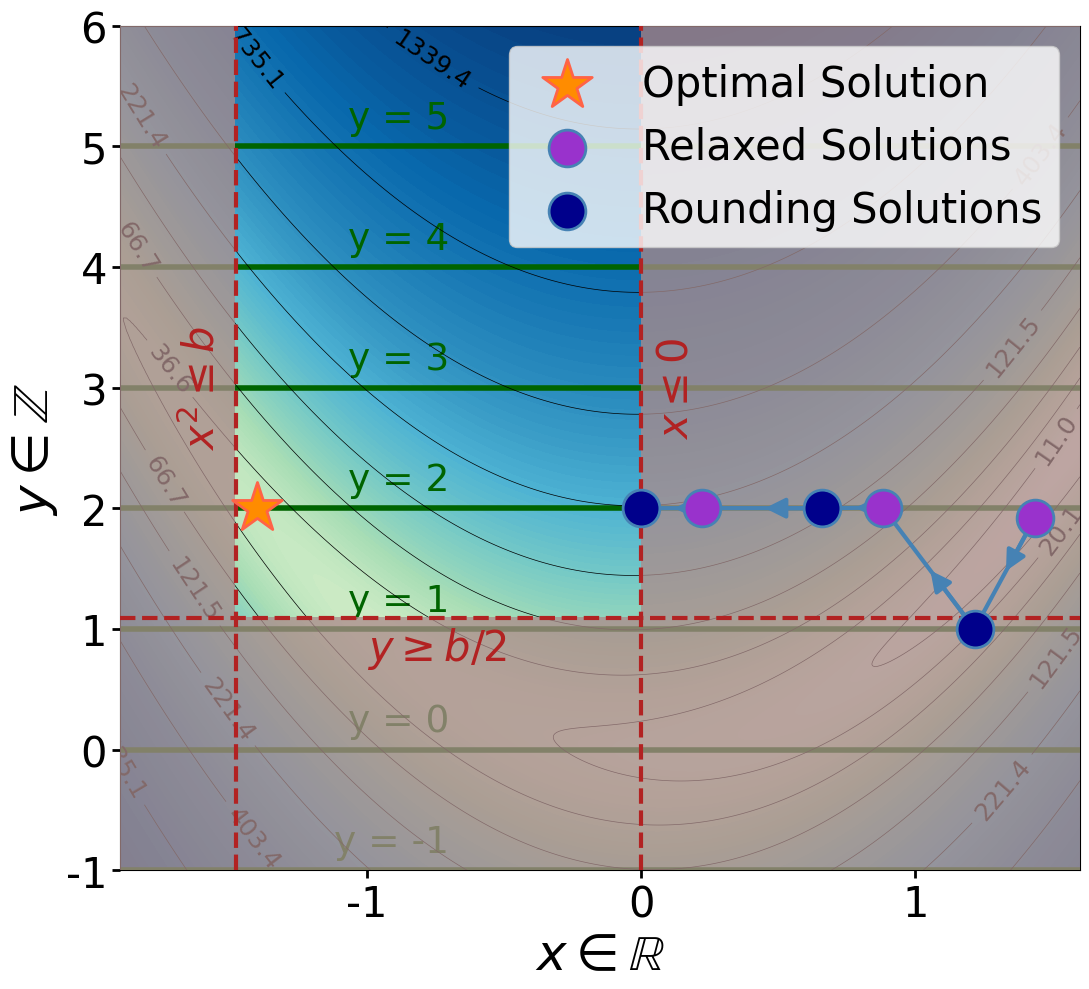

In [22]:
# plot
fig, ax = plt.subplots(figsize=(11, 10))
# contour map
contour_levels = np.linspace(Z_log.min(), Z_log.max(), 100)
contour = ax.contourf(X, Y, Z_log, levels=contour_levels, cmap="GnBu", zorder=0)
# integer y
for y_int in range(-1,6):
    ax.axhline(y=y_int, color="darkgreen", linewidth=4, zorder=1)
    ax.text(-0.7, y_int+0.15, f"y = {y_int}", color="darkgreen", fontsize=27, ha="right", zorder=1)
# add colar bar
#cbar = fig.colorbar(contour, ax=ax)
#log_ticks = np.linspace(Z_log.min(), Z_log.max(), num=10)
#cbar.set_ticks(log_ticks)
#cbar.set_ticklabels([f"{np.exp(tick):.1f}" for tick in log_ticks])
#cbar.set_label("Objective Value")
# add cotour line
contour_lines = ax.contour(X, Y, Z_log, levels=10, colors="black", linewidths=0.5, zorder=2)
ax.clabel(contour_lines, fmt=lambda val: f"{np.exp(val):.1f}", fontsize=18, zorder=2)
# infeasible region
infeasible_region = np.logical_not(constraint_mask)
ax.contourf(X, Y, infeasible_region, levels=[0.5, 1], colors="rosybrown", alpha=0.7, zorder=3)
ax.contourf(X, Y, infeasible_region, levels=[0.5, 1], colors="grey", alpha=0.2, zorder=3)
# constraints
ax.axvline(x=0, color="firebrick", linestyle="--", lw=3, zorder=4)
ax.text(0.05, 3, "$x \leq 0$", color="firebrick", fontsize=30, ha="left", va="center", rotation=90, zorder=4)
ax.axvline(x=-np.sqrt(p.item()), color="firebrick", linestyle="--", lw=3, zorder=4)
ax.text(-np.sqrt(p.item())-0.2, 3, "$x^2 \leq b$", color="firebrick", fontsize=30, ha="left", va="center", rotation=90, zorder=4)
ax.axhline(p.item()/2, color="firebrick", linestyle="--", lw=3, zorder=4)
ax.text(-1.0, p.item()/2-0.25, "$y \geq b / 2$", color="firebrick", fontsize=30, ha="left", va="center", rotation=0, zorder=4)
# solution
ax.scatter([solvals["x"][0]], [solvals["x"][1]], marker="*", color="darkorange", linewidths=2, 
            edgecolors="tomato", s=1400, label="Optimal Solution", zorder=8)
ax.scatter(rels[:,0], rels[:,1], marker="o", color="darkorchid", 
           edgecolors="steelblue", linewidths=2, s=700, label="Relaxed Solutions", zorder=7)
ax.scatter(rnds[:,0], rnds[:,1], marker="o", color="darkblue", 
           edgecolors="steelblue", linewidths=2, s=700, label="Rounding Solutions", zorder=7)
for i in range(len(sol_seq)-1):
    ax.annotate('', xy=(sol_seq[i+1,0], sol_seq[i+1,1]), xytext=(sol_seq[i,0], sol_seq[i,1]),
                arrowprops=dict(arrowstyle="-", color="steelblue", lw=3, ls="-", mutation_scale=20), zorder=6)
    ax.annotate('', xy=((sol_seq[i+1,0]+sol_seq[i,0])/2, (sol_seq[i+1,1]+sol_seq[i,1])/2), xytext=(sol_seq[i,0], sol_seq[i,1]),
                arrowprops=dict(arrowstyle="-|>", color="steelblue", lw=3, ls="-", mutation_scale=30), zorder=6)
# ticks
ax.tick_params(axis='both', which='major', labelsize=24, length=6, width=2)
ax.set_xticks(range(-2,2))
ax.set_xticklabels(range(-2, 2), fontsize=30)
ax.set_yticks(range(-1,7))
ax.set_yticklabels(range(-1, 7), fontsize=30)
# set lim
ax.set_xlim(-1.9, 1.6)
ax.set_ylim(-1, 6)
# label
#ax.set_title("Different Epochs of Training for the Same Instance", fontsize=48)
ax.set_xlabel("$x \in \mathbb{R}$", fontsize=36)
ax.set_ylabel("$y \in \mathbb{Z}$", fontsize=36)
ax.legend(fontsize=30)
# show
plt.tight_layout()
plt.savefig("./img/example2.pdf", format="pdf", bbox_inches="tight")
plt.show()